In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import glob
import seaborn as sns
import numpy as np

## Read from `~/metrics/epoch_metrics/` directory

In [111]:
files = glob.glob("../../metrics/epoch_metrics/*parquet")

dataframes = []

for file in files:
    df = pd.read_parquet(file)
    
    dataframes.append(df)

df = pd.concat(dataframes, ignore_index=True)

In [112]:
df["per_layer"] = df['total_rounds'].apply(lambda x: not isinstance(x, int))

In [113]:
import ast

def per_layer_columns(row):
    if row['per_layer']:
        
        tot_rounds = row['total_rounds']
        
        if isinstance(tot_rounds, str):
            return ast.literal_eval(row['total_rounds'])
        
        elif isinstance(row['total_rounds'], np.ndarray):
            return list(row['total_rounds'])
            
        else:
            print(type(row['total_rounds']))
            raise Exception("WTF")
    
    return row['total_rounds']

In [114]:
df['total_rounds'] = df.apply(per_layer_columns, axis=1)

In [115]:
#df = pd.read_parquet("../../metrics/epoch_metrics/")

In [116]:
def strat_name(fda_name):
    if fda_name == 'synchronous':
        return "Synchronous"
    if fda_name == 'naive':
        return "NaiveFDA"
    if fda_name == 'linear':
        return "LinearFDA"
    if fda_name == 'sketch':
        return "SketchFDA"
    return fda_name

In [117]:
df['strat_name'] = df['fda_name'].apply(strat_name)

In [118]:
def training_error(train_accuracy):
    if pd.isna(train_accuracy):
        return np.nan
    return 1 - train_accuracy

In [119]:
df['training_error'] = df['train_accuracy'].apply(training_error)

In [120]:
df.columns

Index(['dataset_name', 'fda_name', 'num_clients', 'batch_size',
       'num_steps_until_rtc_check', 'theta', 'nn_name', 'nn_num_weights',
       'sketch_width', 'sketch_depth', 'epoch', 'total_rounds',
       'total_fda_steps', 'accuracy', 'bias', 'aggr_scheme', 'train_accuracy',
       'per_layer', 'strat_name', 'training_error'],
      dtype='object')

In [121]:
df_fda_regression = None

# Hyper-Parameters

`bias` `NaN` -> no bias

`bias` $ \in (0, 1)$ -> `bias`% of each client's dataset is biased (from sorted sequence of MNIST) - rest is good

`bias` $= -1$ -> MNIST label 0 is sorted, placed at the start, and clients get assigned sequentially from this dataset. Only one label is biased to however many clients can get it assigned to them.

`bias` $= -2$ -> MNIST label 8 is sorted, placed at the start, and clients get assigned sequentially from this dataset. Only one label is biased to however many clients can get it assigned to them.

In [122]:
one_label_bias = {
    -1: 0,
    -2: 8
}

In [123]:
aggr = {
    'avg': '',
    'wavg_drifts': ' wavg'
}

In [124]:
per_layer_dict = {
    False: '',
    True: ' per-layer'
}

In [125]:
def bias_string_helper(bias):
    if pd.isna(bias):
        return '_no_bias'
    if bias > 0:
        return f"_bias_uniform{str(bias).replace('.', '')}"
    return f"_bias_label{one_label_bias[bias]}"

In [126]:
def bias_title_helper(bias):
    if pd.isna(bias):
        return 'IID'
    if bias > 0:
        return f"{bias * 100}% non-IID"
    return f'Label "{one_label_bias[bias]}" non-IID'

# Helpful new Dataframe metrics

### Add Helpful model metrics

In [127]:
df['model_bytes'] = df['nn_num_weights'] * 4

### Add Helpful FDA method metrics

In [128]:
def fda_local_state_bytes(row):
    if row['fda_name'] == "naive":
        return 4
    if row['fda_name'] == "linear":
        return 8
    if row['fda_name'] == "sketch":
        return row['sketch_width'] * row['sketch_depth'] * 4 + 4
    if row['fda_name'] in ["synchronous", "FedAdam", "FedAvgM"]:
        return 0
    if row['fda_name'] == 'gm':
        return 0.125  # one bit

In [129]:
df['local_state_bytes'] = df.apply(fda_local_state_bytes, axis=1)

### Add Total Steps

total steps (a single fda step might have many normal SGD steps, batch steps)

In [130]:
df['total_steps'] = df['total_fda_steps'] * df['num_steps_until_rtc_check']

### Add communication metrics

In [131]:
adv_layer_count = [640, 36928, 73856, 147584, 295168, 590080, 1180160, 262656, 5130]
lenet_layer_count = [156, 2416, 48120, 10164, 850]

The communication bytes exchanged for model synchronization. Remember that the Clients send their models to the Server and the Server sends the global model back. This happens at the end of every round.

In [132]:
def model_bytes_exchanged(row):
    if row['per_layer']:
        if row['nn_name'] == 'AdvancedCNN':
            return sum((layer_num_weights * 4) * layer_rounds * row['num_clients'] * 2 for layer_num_weights, layer_rounds in zip(adv_layer_count, row['total_rounds']))
        if row['nn_name'] == 'LeNet-5':
            print("lenet?")
            return sum((layer_num_weights * 4) * layer_rounds * row['num_clients'] * 2 for layer_num_weights, layer_rounds in zip(lenet_layer_count, row['total_rounds']))
    
    return row['total_rounds'] * row['model_bytes'] * row['num_clients'] * 2

In [133]:
df['model_bytes_exchanged'] = df.apply(model_bytes_exchanged, axis=1)

The communication bytes exchanged for monitoring the variance. This happens at the end of every FDA step which consists of `num_steps_until_rtc_check` number of steps. 

In [134]:
def monitoring_bytes_exchanged(row):
    if row['per_layer']:
        if row['nn_name'] == 'AdvancedCNN':
            return row['local_state_bytes'] * row['total_fda_steps'] * row['num_clients'] * len(adv_layer_count)
        if row['nn_name'] == 'LeNet-5':
            return row['local_state_bytes'] * row['total_fda_steps'] * row['num_clients'] * len(lenet_layer_count)
    
    return row['local_state_bytes'] * row['total_fda_steps'] * row['num_clients']

In [135]:
df['monitoring_bytes_exchanged'] = df.apply(monitoring_bytes_exchanged, axis=1)

The total communication bytes exchanged in the whole Federated Learning lifecycle.

In [136]:
df['total_communication_bytes'] = df['model_bytes_exchanged'] + df['monitoring_bytes_exchanged']

In [137]:
df['total_communication_gb'] = df['total_communication_bytes'] / 10**9

# HyperParameter ranking

### LeNet-5 - MNIST
On `Nvidia A10`:
1. Batch Size = 32 -> 6.613 ms ± 0.128 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2. *Batch Size* = 64 -> 7.509 ms ± 0.065 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3. *Batch Size* = 128 -> 8.02 ms ± 0.099 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4. *Batch Size* = 256 -> 9.258 ms ± 0.336 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

### AdvancedCNN - MNIST

On `Nvidia A10`:
1. *Batch Size* = 32 -> 8.853 ms ± 0.0917 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2. *Batch Size* = 64 -> 10.325 ms ± 0.215 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3. *Batch Size* = 128 -> 11.989 ms ± 0.134 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4. *Batch Size* = 256 -> 16.47 ms ± 0.294 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

### DenseNet121 - CIFAR10

On `Nvidia A10`:
1. *Batch Size* = 32 -> 87.328 ms ± 0.9547 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2. *Batch Size* = 64 -> 88.832 ms ± 2.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3. *Batch Size* = 128 -> 94.208 ms ± 2.634 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4. *Batch Size* = 256 -> 96.0 ms ± 2.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

### DenseNet201 - CIFAR10

On `Nvidia A10`:
1. *Batch Size* = 32 -> 142.0896 ms ± 2.9547 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2. *Batch Size* = 64 -> 150.2592 ms ± 5.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3. *Batch Size* = 128 -> 154.5664 ms ± 6.758 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4. *Batch Size* = 256 -> 156.5776 ms ± 7.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [138]:
step_ms = {
    ("AdvancedCNN", 32): 8.853,
    ("AdvancedCNN", 64): 10.325,
    ("AdvancedCNN", 128): 11.989,
    ("AdvancedCNN", 256): 16.47,
    ("LeNet-5", 32): 6.613,
    ("LeNet-5", 64): 7.509,
    ("LeNet-5", 128): 8.02,
    ("LeNet-5", 256): 9.258,
    ("DenseNet121", 32): 87.328,
    ("DenseNet121", 64): 88.832,
    ("DenseNet121", 128): 94.208,
    ("DenseNet121", 256): 96.0,
    ("DenseNet201", 32): 142.0896,
    ("DenseNet201", 64): 150.2592,
    ("DenseNet201", 128): 154.5664,
    ("DenseNet201", 256): 156.5776,
    
    ("ConvNeXtLarge", 32): 368.328,
}

In [139]:
import numpy as np

def cpu_time_cost(row):
    """ Total cpu time cost in (sec).
    A single `step` means each client performed a single `step` 
    """
    return row['total_steps'] * step_ms[(row['nn_name'], row['batch_size'])] / 1000

def communication_time_cost(num_clients, total_communication_bytes, comm_model):
    """ Assuming channel is 1Gbps """

    G = 0.5  # Gbps
    total_communication_gbit = total_communication_bytes * 8e-9

    if comm_model == 'common_channel':
        
        return ((num_clients - 1) / num_clients) * (total_communication_gbit / G)    # sec

    if comm_model == 'hypercube':

        return (np.ceil(np.log(num_clients)) / num_clients) * (total_communication_gbit / G)   # sec

In [140]:
df['cpu_time_cost'] = df.apply(cpu_time_cost, axis=1)

In [141]:
df['hypercube_communication_time_cost'] = communication_time_cost(df['num_clients'], df['total_communication_bytes'], 'hypercube')

In [142]:
df['common_channel_communication_time_cost'] = communication_time_cost(df['num_clients'], df['total_communication_bytes'], 'common_channel')

In [143]:
df['hypercube_time_cost'] = df['cpu_time_cost'] + df['hypercube_communication_time_cost']

In [144]:
df['common_channel_time_cost'] = df['cpu_time_cost'] + df['common_channel_communication_time_cost']

In [145]:
df['hypercube_comm_cpu_time_ratio'] = df['hypercube_communication_time_cost'] / df['cpu_time_cost']

In [146]:
df['common_channel_comm_cpu_time_ratio'] = df['common_channel_communication_time_cost'] / df['cpu_time_cost']

# Plots about cost

In [147]:
fda_names = ['gm', 'naive', 'linear', 'sketch', 'FedAvgM', 'FedAdam', 'synchronous']

In [148]:
import matplotlib

num_clients_values = sorted(df['num_clients'].unique())
cmap = matplotlib.colormaps['tab20b']
colors_dict = {
    num_clients: color 
    for num_clients, color in zip(num_clients_values, cmap(np.linspace(0, 1, len(num_clients_values))))
}

## KDE Helper

In [149]:
"""
sns_params = {
    'bw_method': 'scott',
    'bw_adjust': 0.7,
    'fill': True,
    'alpha': 0.2
}
"""
sns_params = {
    'bw_method': 'scott',
    'bw_adjust': 0.7,
    'fill': False,
    'alpha': 1
}

sns_params_biases = {
    'bw_method': 'scott',
    'bw_adjust': 0.7,
    'fill': False,
    'alpha': 0.8
}

base_colors = {
    'gm': 'black',
    'naive': 'orange',
    'NaiveFDA': 'orange',
    'linear': 'green',
    'LinearFDA': 'green',
    'sketch': 'red',
    'SketchFDA': 'red',
    #'synchronous': 'darkslategrey',
    #'Synchronous': 'darkslategrey',
    'synchronous': 'black',
    'Synchronous': 'black',
    'sketch wavg': 'black',
    'FedAvgM': 'purple',
    'FedAdam': 'blue'
}

markers = {
    'gm': '.',
    'naive': 'v',
    'NaiveFDA': 'v',
    'linear': '^',
    'LinearFDA': '^',
    'sketch': '*',
    'SketchFDA': '*',
    'synchronous': 's',
    'Synchronous': 's',
    'FedAvgM': 'o',
    'FedAdam': 'o'
}


fda_strat_names = ["NaiveFDA", "LinearFDA", "SketchFDA"]
other_strat_names = ["FedAvgM", "FedAdam", "Synchronous"]

In [150]:
strat_legend_order = {'gm': 0, 'NaiveFDA': 1, 'LinearFDA': 2, 'SketchFDA': 3, 'FedAvgM': 4, 'FedAdam': 5, 'Synchronous': 6}

In [151]:
def get_ordered_handles_and_labels(handles, labels):
    
    handles_labels = [(h, l, strat_legend_order[l]) for h, l in zip(handles, labels)]
    
    handles_labels.sort(key=lambda x: x[2])
    
    handles, labels = [], []
    
    for h, l, _ in handles_labels:
        labels.append(l)
        handles.append(h)
    
    return handles, labels

In [152]:
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 12.0
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

In [153]:
#import matplotlib
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [154]:
from pathlib import Path
import matplotlib as mpl

#fig, ax = plt.subplots()

fpath = Path(mpl.get_data_path(), "/usr/share/fonts/opentype/linux-libertine/LinLibertine_RB.otf")
#ax.set_title('Non-IID: Label "$0$", Accuracy Target: $0.975$', font=fpath, size=20)
#ax.set_xlabel('This is the default font')

#plt.show()

In [155]:
def bias_title(bias):
    if pd.isna(bias):
        return "IID"
    elif bias > 0:
        return f"Non-IID: ${int(bias * 100)}\%$"
    elif bias == -1:
        return 'Non-IID: Label "$0$"'
    elif bias == -2:
        return 'Non-IID: Label "$8$"'

In [156]:
df['bias'].unique()

array([ nan, -2. ,  0.9, -1. ,  0.6,  0.2,  0.3,  0.5])

## Biparte

In [157]:
sns_params_joint = {
    'bw_method': 'scott',
    'bw_adjust': 0.5,
    'alpha': 0.4, # 0.8
    'n_levels': 4,
    'fill': True,
}

sns_params_joint_tmp = {
    'bw_method': 'scott',
    'bw_adjust': 0.5,
    'fill': False,
    'alpha': 0.8,
    'n_levels': 4
}

In [158]:
def kde_joint(df, filepath, x_log=True, y_log=False, loc='best', filter_cpu_time_problem=None, show_legend=False, acc_target=0.975, nn_name=None):

    log_scale = (x_log, y_log)
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
        elif bias > 0:
            mask = df['bias'] == bias
        else:
            mask = df['bias'] == bias
            
        df_bias = df[mask]
        
        # Lone point in VGG16* causes problems in distribution. Filter it
        if filter_cpu_time_problem:
            df_bias = df_bias[df_bias['cpu_time_cost'] < filter_cpu_time_problem]
        
        if df_bias.empty or len(df_bias['fda_name'].unique()) < 1:
            continue
        
        if (len(df_bias[df_bias.fda_name == 'linear']) == 1 or df_bias[df_bias.fda_name == 'linear'].empty or
            len(df_bias[df_bias.fda_name == 'sketch']) == 1 or df_bias[df_bias.fda_name == 'sketch'].empty or
            len(df_bias[df_bias.fda_name == 'synchronous']) == 1) or df_bias[df_bias.fda_name == 'synchronous'].empty:
            continue
              
        bias_filename = f"{filepath}/joint_costs{bias_string_helper(bias)}.pdf"
        pdf = PdfPages(bias_filename)
        
        plt.figure(figsize=(6.7, 4.8))

        g = sns.kdeplot(df_bias, x='total_communication_gb', y='total_fda_steps', hue='strat_name', log_scale=log_scale, palette=base_colors, legend=False, **sns_params_joint_tmp)
        g = sns.kdeplot(df_bias, x='total_communication_gb', y='total_fda_steps', hue='strat_name', log_scale=log_scale, palette=base_colors, legend=show_legend, **sns_params_joint)
        
        # Set x and y limits if not log scale
        if not x_log:
            plt.xlim(left=0)

        if not y_log:
            plt.ylim(bottom=0)

        # Add grid
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

        # Set axis labels
        g.set_xlabel("Communication (GB)")
        g.set_ylabel("In-Parallel Learning Steps")

        # Modify the legend
        legend = g.get_legend()
        
        if legend:
            handles, labels = get_ordered_handles_and_labels(legend.legendHandles, [t.get_text() for t in legend.get_texts()])
            g.legend_.remove()
            g.legend(handles, labels)
            
            legend.set_title(None)
            #legend.set_loc('center left')
            sns.move_legend(g, loc)

        
        fda_df = df_bias[~df_bias.fda_name.isin(['synchronous', 'FedAdam', 'FedAvgM'])]
        sync_df = df_bias[df_bias['fda_name'] == 'synchronous']
        
        #general = f"All strategies : {bias_title}  ,  bs : 32\n"
        #fda_info = f"FDA :  Θ {sorted(list(fda_df['theta'].unique()))}"
        
        n = f"{nn_name}, " if nn_name else ''
        
        plt.title(f"{n}{bias_title(bias)}, Accuracy Target: ${acc_target}$", font=fpath, size=22)

        #plt.tight_layout()

        pdf.savefig(plt.gcf()) # Save the current figure

        # Close the current figure to prevent it from being displayed in the notebook
        plt.close()
        pdf.close()

## On K

In [159]:
def fda_methods_clients_comm_cost(df, filepath, show_legend=False, loc='best'):
    # per-layer stuff are already filter out.
    df = df[~df.per_layer]
    
    batch_size_values = sorted(df['batch_size'].unique())
    theta_values = sorted(df['theta'].unique())[1:]
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]
    
    min_clients = min(df['num_clients'])
    max_clients = max(df['num_clients'])
    
    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
        elif bias > 0:
            mask = df['bias'] == bias
        else:
            mask = df['bias'] == bias
            
        df_bias = df[mask]
        
        for batch_size in batch_size_values:
            
            df_bs = df_bias[df_bias['batch_size'] == batch_size]
            
            for theta in theta_values:

                df_theta = df_bs[(df_bs['theta'] == theta)] 

                if df_theta.empty:
                    continue
                    
                filename = f"{filepath}/clients_comm_th{str(theta).replace('.', '')}_bs{batch_size}{bias_string_helper(bias)}.pdf"
                pdf = PdfPages(filename)

                plt.figure(figsize=(6.7, 4.8))

                for fda_strat_name in fda_strat_names:

                    fda_data = df_theta[df_theta['strat_name'] == fda_strat_name]

                    if fda_data.empty:
                        continue

                    plt.plot(fda_data['num_clients'], fda_data['total_communication_gb'], marker=markers[fda_strat_name], color=base_colors[fda_strat_name], label=fda_strat_name, markersize=5)

                for other_strat_name in other_strat_names:
                    df_strat = df_bs[df_bs['strat_name'] == other_strat_name]

                    if df_strat.empty:
                        continue

                    plt.plot(df_strat['num_clients'], df_strat['total_communication_gb'], marker=markers[other_strat_name], color=base_colors[other_strat_name], label=other_strat_name, markersize=5)

                    
                x_ticks = list(range(min_clients, max_clients + 1, 5))

                plt.yscale('log')
                plt.xticks(x_ticks)
                plt.xlabel('K - Number of Workers')
                    
                plt.ylabel('Communication (GB)')
                plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
                
                if show_legend:
                    plt.legend(loc=loc)

                #title = f'Batch Size : {batch_size} , $\Theta$ : {theta} , {bias_title}'
                #plt.suptitle(title)
                plt.title(f"{bias_title(bias)}, $\Theta = {int(theta)}$", font=fpath, size=22)
                
                pdf.savefig(plt.gcf()) # Save the current figure

                # Close the current figure to prevent it from being displayed in the notebook
                plt.close()
                pdf.close()

In [160]:
def fda_methods_clients_steps(df, filepath, legend_loc='best', show_legend=False):
    # per-layer stuff are already filter out.
    df = df[~df.per_layer]
    
    batch_size_values = sorted(df['batch_size'].unique())
    theta_values = sorted(df['theta'].unique())[1:]
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]
    
    min_clients = min(df['num_clients'])
    max_clients = max(df['num_clients'])

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
        elif bias > 0:
            mask = df['bias'] == bias
        else:
            mask = df['bias'] == bias
            
        df_bias = df[mask]
        
        for batch_size in batch_size_values:
            
            df_bs = df_bias[df_bias['batch_size'] == batch_size]
            
            for theta in theta_values:

                df_theta = df_bs[(df_bs['theta'] == theta)] 

                if df_theta.empty:
                    continue
                    
                filename = f"{filepath}/clients_cpu_th{str(theta).replace('.', '')}_bs{batch_size}{bias_string_helper(bias)}.pdf"
                pdf = PdfPages(filename)

                plt.figure(figsize=(6.7, 4.8))

                for fda_strat_name in fda_strat_names:

                    fda_data = df_theta[df_theta['strat_name'] == fda_strat_name]

                    if fda_data.empty:
                        continue

                    plt.plot(fda_data['num_clients'], fda_data['total_fda_steps'], marker=markers[fda_strat_name], color=base_colors[fda_strat_name], label=fda_strat_name, markersize=5)

                for other_strat_name in other_strat_names:
                    df_strat = df_bs[df_bs['strat_name'] == other_strat_name]

                    if df_strat.empty:
                        continue

                    plt.plot(df_strat['num_clients'], df_strat['total_fda_steps'], marker=markers[other_strat_name], color=base_colors[other_strat_name], label=other_strat_name, markersize=5)

                    
                x_ticks = list(range(min_clients, max_clients + 1, 5))

                plt.yscale('log')
                plt.xticks(x_ticks)
                plt.xlabel('K - Number of Workers')
                
                if show_legend:
                    plt.legend(loc=legend_loc)
                    
                plt.ylabel('In-Parallel Learning Steps')
                plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                #title = f'Batch Size : {batch_size} , $\Theta$ : {theta} , {bias_title}'
                #plt.suptitle(title)
                plt.title(f"{bias_title(bias)}, $\Theta = {int(theta)}$", font=fpath, size=22)
                
                pdf.savefig(plt.gcf()) # Save the current figure

                # Close the current figure to prevent it from being displayed in the notebook
                plt.close()
                pdf.close()

In [161]:
from matplotlib.ticker import LogLocator

In [162]:
# Function to calculate subs based on desired minor ticks per decade
def calculate_subs(minor_ticks_per_decade):
    # Generate evenly spaced ticks within each decade
    return [i / minor_ticks_per_decade for i in range(1, minor_ticks_per_decade)]

In [207]:
def fda_methods_clients_comm_steps_cost(df, filepath, show_legend=True, loc='best'):
    # per-layer stuff are already filter out.
    df = df[~df.per_layer]
    
    batch_size_values = sorted(df['batch_size'].unique())
    theta_values = sorted(df['theta'].unique())[1:]
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]
    
    min_clients = min(df['num_clients'])
    max_clients = max(df['num_clients'])

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
        elif bias > 0:
            mask = df['bias'] == bias
        else:
            mask = df['bias'] == bias
            
        df_bias = df[mask]
        
        for batch_size in batch_size_values:
            
            df_bs = df_bias[df_bias['batch_size'] == batch_size]
            
            for theta in theta_values:

                df_theta = df_bs[(df_bs['theta'] == theta)] 

                if df_theta.empty:
                    continue
                    
                filename = f"{filepath}/clients_COMM_CPU_th{str(theta).replace('.', '')}_bs{batch_size}{bias_string_helper(bias)}.pdf"
                pdf = PdfPages(filename)

                #plt.figure(figsize=(6.7, 4.8))
                fig, axs = plt.subplots(2, figsize=(6.7, 5), sharex=True,)
                ax1 = axs[0]
                ax2 = axs[1]

                for fda_strat_name in fda_strat_names:

                    fda_data = df_theta[df_theta['strat_name'] == fda_strat_name]

                    if fda_data.empty:
                        continue

                    ax1.plot(fda_data['num_clients'], fda_data['total_communication_gb'], marker=markers[fda_strat_name], color=base_colors[fda_strat_name])
                    
                    ax2.plot(fda_data['num_clients'], fda_data['total_fda_steps'], marker=markers[fda_strat_name], color=base_colors[fda_strat_name], label=fda_strat_name, markersize=5)
                    
                
                for other_strat_name in other_strat_names:
                    df_strat = df_bs[df_bs['strat_name'] == other_strat_name]

                    if df_strat.empty:
                        continue
                    
                    ax1.plot(df_strat['num_clients'], df_strat['total_communication_gb'], marker=markers[other_strat_name], color=base_colors[other_strat_name])
                    
                    ax2.plot(df_strat['num_clients'], df_strat['total_fda_steps'], marker=markers[other_strat_name], color=base_colors[other_strat_name], label=other_strat_name, markersize=5)


                    
                x_ticks = list(range(min_clients, max_clients + 1, 5))

                plt.yscale('log')
                
                ax1.set_yscale('log')
                ax2.set_yscale('log')
                
                ax1.set_xticks(x_ticks)
                ax2.set_xticks(x_ticks)
                
                #ax1.tick_params(axis='y', which='both', length=7, width=0.1)
                #ax2.tick_params(axis='y', which='both', length=7, width=0.1)
                
                #ax2.yaxis.set_minor_locator(LogLocator(base=10, numticks=5))
                #ax1.yaxis.set_minor_locator(LogLocator(base=10, numticks=5))
                
                # Set minor ticks to 3 per decade
                #minor_ticks_per_decade = 5  # We use 4 because we include the major tick (e.g., for a decade 10-100, we place at 20, 40, 60, 80)
                #subs = calculate_subs(minor_ticks_per_decade)
                #ax1.yaxis.set_minor_locator(LogLocator(base=10, subs=subs))
                #ax2.yaxis.set_minor_locator(LogLocator(base=10, subs=subs))
                
                if show_legend:
                    ax2.legend(loc=loc)
                
                plt.xlabel('K - Number of Workers')
            
                ax1.set_ylabel('Communication (GB)')
                ax2.set_ylabel('In-Parallel Learning Steps')
                
                #ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)

                ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
                ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
                
                # Move the y-axis label and ticks to the right for the second subplot
                ax2.yaxis.set_label_position("right")
                ax2.yaxis.tick_right()

                ax1.set_title(f"{bias_title(bias)}, $\Theta = {int(theta)}$", font=fpath, size=22)   
                
                plt.subplots_adjust(left=0.12, right=0.88)
                
                pdf.savefig(plt.gcf()) # Save the current figure

                # Close the current figure to prevent it from being displayed in the notebook
                plt.close()
                pdf.close()

## On Θ

In [164]:
def fda_methods_theta_comm_cost(df, filepath, show_legend=False, loc='best', lim_from_zero=True, show_other=False):
    # per-layer stuff are already filter out.
    df = df[~df.per_layer]
    
    batch_size_values = sorted(df['batch_size'].unique())
    num_clients_values = sorted(df['num_clients'].unique())
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
        elif bias > 0:
            mask = df['bias'] == bias
        else:
            mask = df['bias'] == bias
            
        df_bias = df[mask]
        
        for batch_size in batch_size_values:
            
            df_bs = df_bias[df_bias['batch_size'] == batch_size]
            
            for num_clients in num_clients_values:

                df_k = df_bs[df_bs['num_clients'] == num_clients] 

                if df_k.empty:
                    continue
                    
                add = '_other' if show_other else ''
                filename = f"{filepath}/theta_comm_k{num_clients}_bs{batch_size}{bias_string_helper(bias)}{add}.pdf"
                pdf = PdfPages(filename)

                plt.figure(figsize=(6.7, 4.8))
                
                max_comm_cost = 0

                for fda_strat_name in fda_strat_names:

                    fda_data = df_k[df_k['strat_name'] == fda_strat_name]

                    if fda_data.empty:
                        continue
                        
                    max_comm_cost = max(max_comm_cost, max(fda_data['total_communication_gb']))

                    plt.plot(fda_data['theta'], fda_data['total_communication_gb'], marker=markers[fda_strat_name], color=base_colors[fda_strat_name], label=fda_strat_name, markersize=5)
                    
                if show_other:
                    for other_strat_name in other_strat_names:
                        df_strat = df_k[df_k['strat_name'] == other_strat_name]

                        if df_strat.empty:
                            continue

                        # Assuming df_strat is already defined and has the 'total_communication_gb' column
                        val = df_strat['total_communication_gb'].iloc[0]
                        
                        assert len(df_strat['total_communication_gb']) == 1
                        plt.axhline(y=val, linestyle='-', label=other_strat_name, color=base_colors[other_strat_name])
                    
                if show_other:
                    plt.yscale('log') # change
                    
                plt.xlabel('$\Theta$ - Variance Threshold')
                if show_legend:
                    plt.legend(loc=loc)
                plt.ylabel('Communication (GB)')
                plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
                
                if lim_from_zero:
                    plt.ylim([0, max_comm_cost*1.1])

                #title = f'Batch Size : {batch_size} , $\Theta$ : {theta} , {bias_title}'
                #plt.suptitle(title)
                plt.title(f"{bias_title(bias)}, $K = {num_clients}$", font=fpath, size=22)
                
                pdf.savefig(plt.gcf()) # Save the current figure

                # Close the current figure to prevent it from being displayed in the notebook
                plt.close()
                pdf.close()

In [165]:
def fda_methods_theta_steps(df, filepath, show_legend=False, loc='best', show_other=False, lim_from_zero=True):
    # per-layer stuff are already filter out.
    df = df[~df.per_layer]
    
    batch_size_values = sorted(df['batch_size'].unique())
    num_clients_values = sorted(df['num_clients'].unique())
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
        elif bias > 0:
            mask = df['bias'] == bias
        else:
            mask = df['bias'] == bias
            
        df_bias = df[mask]
        
        for batch_size in batch_size_values:
            
            df_bs = df_bias[df_bias['batch_size'] == batch_size]
            
            for num_clients in num_clients_values:

                df_k = df_bs[df_bs['num_clients'] == num_clients] 

                if df_k.empty:
                    continue
                    
                add = '_other' if show_other else ''
                    
                filename = f"{filepath}/theta_cpu_k{num_clients}_bs{batch_size}{bias_string_helper(bias)}{add}.pdf"
                pdf = PdfPages(filename)

                plt.figure(figsize=(6.7, 4.8))
                
                max_steps = 0

                for fda_strat_name in fda_strat_names:

                    fda_data = df_k[df_k['strat_name'] == fda_strat_name]

                    if fda_data.empty:
                        continue
                    
                    max_steps = max(max_steps, max(fda_data['total_fda_steps']))

                    plt.plot(fda_data['theta'], fda_data['total_fda_steps'], marker=markers[fda_strat_name], color=base_colors[fda_strat_name], label=fda_strat_name, markersize=5)
         
                if show_other:
                    for other_strat_name in other_strat_names:
                        df_strat = df_k[df_k['strat_name'] == other_strat_name]

                        if df_strat.empty:
                            continue

                        # Assuming df_strat is already defined and has the 'total_communication_gb' column
                        val = df_strat['total_fda_steps'].iloc[0]
                        
                        assert len(df_strat['total_fda_steps']) == 1
                        plt.axhline(y=val, linestyle='-', label=other_strat_name, color=base_colors[other_strat_name])
                    
                if show_other:
                    plt.yscale('log') # change
                
                plt.xlabel('$\Theta$ - Variance Threshold')
                if show_legend:
                    plt.legend(loc=loc)
                plt.ylabel('In-Parallel Learning Steps')
                plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
                
                if lim_from_zero:
                    plt.ylim([0, max_steps*1.1])
                
                # ----------------------------
                ax = plt.gca()

                # Enable scientific notation
                if not show_other:
                    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)

                # Adjust the position of the scientific notation exponent
                #ax.yaxis.get_offset_text().set_position((1,10))
                
                # ----------------------------

                #title = f'Batch Size : {batch_size} , $\Theta$ : {theta} , {bias_title}'
                #plt.suptitle(title)
                plt.title(f"{bias_title(bias)}", font=fpath, size=22)
                
                pdf.savefig(plt.gcf()) # Save the current figure

                # Close the current figure to prevent it from being displayed in the notebook
                plt.close()
                pdf.close()

In [166]:
def fda_methods_theta_comm_steps_cost(df, filepath, show_legend=False, loc='best', lim_from_zero=True, show_other=False):
    # per-layer stuff are already filter out.
    df = df[~df.per_layer]
    
    batch_size_values = sorted(df['batch_size'].unique())
    num_clients_values = sorted(df['num_clients'].unique())
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
        elif bias > 0:
            mask = df['bias'] == bias
        else:
            mask = df['bias'] == bias
            
        df_bias = df[mask]
        
        for batch_size in batch_size_values:
            
            df_bs = df_bias[df_bias['batch_size'] == batch_size]
            
            for num_clients in num_clients_values:

                df_k = df_bs[df_bs['num_clients'] == num_clients] 

                if df_k.empty:
                    continue
                    
                add = '_other' if show_other else ''
                filename = f"{filepath}/theta_k{num_clients}_bs{batch_size}{bias_string_helper(bias)}{add}.pdf"
                pdf = PdfPages(filename)

                #plt.figure(figsize=(6.7, 4.8))
                fig, axs = plt.subplots(2, figsize=(6.7, 5), sharex=True,)
                ax1 = axs[0]
                ax2 = axs[1]
                
                max_comm_cost = 0
                max_steps = 0

                for fda_strat_name in fda_strat_names:

                    fda_data = df_k[df_k['strat_name'] == fda_strat_name]

                    if fda_data.empty:
                        continue
                        
                    max_comm_cost = max(max_comm_cost, max(fda_data['total_communication_gb']))
                    max_steps = max(max_steps, max(fda_data['total_fda_steps']))

                    ax1.plot(fda_data['theta'], fda_data['total_communication_gb'], marker=markers[fda_strat_name], color=base_colors[fda_strat_name], label=fda_strat_name, markersize=5)
                    
                    ax2.plot(fda_data['theta'], fda_data['total_fda_steps'], marker=markers[fda_strat_name], color=base_colors[fda_strat_name])


                #ax2.set_xlabel('$\Theta$ - Variance Threshold')
                
                plt.xlabel('$\Theta$ - Variance Threshold')
            
                ax1.set_ylabel('Communication (GB)')
                ax2.set_ylabel('In-Parallel Learning Steps')
                
                ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
                
                ax1.tick_params(axis='y', which='both', length=7, width=0.8)
                ax2.tick_params(axis='y', which='both', length=7, width=0.8)
                
                #ax1.set_ylim([0, max_comm_cost*1.1])
                #ax2.set_ylim([0, max_steps*1.1])
            
                if show_legend:
                    ax1.legend(loc=loc)

                ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
                ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
                
                # Move the y-axis label and ticks to the right for the second subplot
                ax2.yaxis.set_label_position("right")
                ax2.yaxis.tick_right()
                
                ax1.tick_params(axis='y', which='both', length=7, width=0.1)
                ax2.tick_params(axis='y', which='both', length=7, width=0.1)
                
                if lim_from_zero:
                    ax1.ylim([0, max_comm_cost*1.1])
                    ax2.set_ylim([0, max_steps*1.1])

                #title = f'Batch Size : {batch_size} , $\Theta$ : {theta} , {bias_title}'
                #plt.suptitle(title)
                ax1.set_title(f"{bias_title(bias)}, $K = {num_clients}$", font=fpath, size=22)
                
                plt.subplots_adjust(left=0.12, right=0.88)
                
                pdf.savefig(plt.gcf()) # Save the current figure

                # Close the current figure to prevent it from being displayed in the notebook
                plt.close()
                pdf.close()

In [167]:
def fda_methods_theta_common_channel_time(df, filepath, show_legend=True):
    # per-layer stuff are already filter out.
    df = df[~df.per_layer]
    
    batch_size_values = sorted(df['batch_size'].unique())
    num_clients_values = sorted(df['num_clients'].unique())
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]
    
    filename = f"{filepath}/COMMON_CHANNEL.pdf"
    pdf = PdfPages(filename)

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
        elif bias > 0:
            mask = df['bias'] == bias
        else:
            mask = df['bias'] == bias
            
        df_bias = df[mask]
        
        for batch_size in batch_size_values:
            
            df_bs = df_bias[df_bias['batch_size'] == batch_size]
            
            for num_clients in num_clients_values:

                df_k = df_bs[df_bs['num_clients'] == num_clients] 

                if df_k.empty:
                    continue

                plt.figure(figsize=(6.7, 4.8))
                
                max_time_cost = 0

                for fda_strat_name in fda_strat_names:

                    fda_data = df_k[df_k['strat_name'] == fda_strat_name]

                    if fda_data.empty:
                        continue
                        
                    max_time_cost = max(max_time_cost, max(fda_data['common_channel_time_cost']))

                    plt.plot(fda_data['theta'], fda_data['common_channel_time_cost'], marker=markers[fda_strat_name], color=base_colors[fda_strat_name], label=fda_strat_name, markersize=5)
                    
                #plt.yscale('log')
                plt.xlabel('$\Theta$ - Variance Threshold')
                if show_legend:
                    plt.legend()
                plt.ylabel('Common Channel Time (sec)')
                plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
                
                plt.ylim([0, max_time_cost*1.1])

                title = f'K : {num_clients} , {bias_title}'
                plt.suptitle(title)
                
                pdf.savefig(plt.gcf()) # Save the current figure

                # Close the current figure to prevent it from being displayed in the notebook
                plt.close()
    pdf.close()

# w/ Regression preds.

In [168]:
def fda_methods_theta_wall_time(df, filepath, show_legend=False, loc='best'):
    # per-layer stuff are already filter out.
    df = df[~df.per_layer]
    
    batch_size_values = sorted(df['batch_size'].unique())
    num_clients_values = sorted(df['num_clients'].unique())
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
        elif bias > 0:
            mask = df['bias'] == bias
        else:
            mask = df['bias'] == bias
            
        df_bias = df[mask]
        
        for batch_size in batch_size_values:
            
            df_bs = df_bias[df_bias['batch_size'] == batch_size]
            
            for num_clients in num_clients_values:

                df_k = df_bs[df_bs['num_clients'] == num_clients] 

                if df_k.empty:
                    continue
                    
                filename = f"{filepath}/regression_wall_time_k{num_clients}_bs{batch_size}{bias_string_helper(bias)}.pdf"
                pdf = PdfPages(filename)

                plt.figure(figsize=(6.7, 4.8))
                
                max_wall_time = 0

                for fda_strat_name in fda_strat_names:

                    fda_data = df_k[df_k['strat_name'] == fda_strat_name]

                    if fda_data.empty:
                        continue
                    
                    max_wall_time = max(max_wall_time, max(fda_data['pred_total_time_minutes']))

                    plt.plot(fda_data['theta'], fda_data['pred_total_time_minutes'], marker=markers[fda_strat_name], color=base_colors[fda_strat_name], label=fda_strat_name, markersize=5)
                    
                #plt.yscale('log')
                plt.xlabel('$\Theta$ - Variance Threshold')
                if show_legend:
                    plt.legend(loc=loc)
                plt.ylabel('Total Wall-Time (min)')
                plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
                
                plt.ylim([0, max_wall_time*1.1])

                #title = f'K : {num_clients} , {bias_title}'
                #plt.suptitle(title)
                plt.title(f"{bias_title(bias)}, ARIS-HPC w/ IB", font=fpath, size=22)
                
                pdf.savefig(plt.gcf()) # Save the current figure

                # Close the current figure to prevent it from being displayed in the notebook
                plt.close()
                pdf.close()

## Training Error

In [169]:
def training_acc_epoch(df, accuracy_target, filepath, nn_name, show_legend=False, loc='best', target_acc=None):
    # per-layer stuff are already filter out.
    df = df[~df.per_layer]
    
    batch_size_values = sorted(df['batch_size'].unique())
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
        elif bias > 0:
            mask = df['bias'] == bias
        else:
            mask = df['bias'] == bias
            
        df_bias = df[mask]
        
        for batch_size in batch_size_values:
            
            df_bs = df_bias[df_bias['batch_size'] == batch_size]
            
            num_clients_values = sorted(df_bs['num_clients'].unique())
            
            for num_clients in num_clients_values:

                df_k = df_bs[df_bs['num_clients'] == num_clients]
                
                theta_values = sorted(df_k['theta'].unique())[1:]
                
                for theta in theta_values:
                    
                    df_th = df_k[df_k['theta'] == theta]

                    if df_th.empty:
                        continue

                    filename = f"{filepath}/training_acc_k{num_clients}_bs{batch_size}_th{int(theta)}{bias_string_helper(bias)}.pdf"

                    pdf = PdfPages(filename)

                    plt.figure(figsize=(6.7, 4.8))

                    max_cpu_cost = 0
                    
                    e_lst = []
                    acc_lst = []
                    n_lst = []

                    for fda_strat_name in fda_strat_names:

                        fda_data = df_th[df_th['strat_name'] == fda_strat_name]
                        
                        df_acc = fda_data[fda_data.accuracy >= accuracy_target]
                        
                        if df_acc.empty:
                            continue

                        min_epoch = min(df_acc.epoch)
                        
                        fda_data = fda_data[fda_data.epoch <= min_epoch]

                        plt.plot(fda_data['epoch'], fda_data['train_accuracy'], marker=markers[fda_strat_name], color=base_colors[fda_strat_name], label=fda_strat_name, markersize=5)
                        
                        
                        e = max(fda_data['epoch'])
                        acc = fda_data.loc[fda_data.epoch == e, 'train_accuracy']
                        
                        e_lst.append(e)
                        acc_lst.append(acc)
                        n_lst.append(fda_strat_name)

                        # Annotate with an arrow
                        
                    for other_strat_name in other_strat_names:
                        df_strat = df_k[df_k['strat_name'] == other_strat_name]

                        df_acc = df_strat[df_strat.accuracy >= accuracy_target]
                        
                        if df_acc.empty:
                            continue

                        min_epoch = min(df_acc.epoch)
                        
                        df_strat = df_strat[df_strat.epoch <= min_epoch]

                        plt.plot(df_strat['epoch'], df_strat['train_accuracy'], marker=markers[other_strat_name], color=base_colors[other_strat_name], label=other_strat_name, markersize=5)
                        
                    
                    if len(e_lst) >= 2:
                        plt.axvline(x=e_lst[0], color=base_colors[n_lst[0]], linestyle='dashed', linewidth=2.2)
                        plt.axvline(x=e_lst[1], color=base_colors[n_lst[1]], linestyle='dotted', linewidth=2.2)
                        
                    
                    plt.axhline(y=target_acc, linestyle='dashdot', linewidth=0.9, color='black')
                    
                    """
                    plt.annotate(
                        f"{n_lst[0]} terminates here", 
                        xy=(e_lst[0], acc_lst[0]), 
                        xytext=(e_lst[0]+90, acc_lst[0] - 0.2),
                        arrowprops=dict(facecolor='gray', arrowstyle='-|>',
                                                 connectionstyle="arc3,rad=-0.3", lw=0.5),
                        fontsize=12
                    )
                    """

                    #plt.xscale('log')
                    plt.ylabel('Training Accuracy')
                    if show_legend:
                        plt.legend(loc=loc)
                    plt.xlabel('Epoch')
                    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                    #title = f'Batch Size : {batch_size} , $\Theta$ : {theta} , {bias_title}'
                    #plt.suptitle(title)
                    plt.title(f"{nn_name} , {bias_title(bias)} , $K = {num_clients}$ , $\Theta = {theta}$", font=fpath, size=22)

                    pdf.savefig(plt.gcf()) # Save the current figure

                    # Close the current figure to prevent it from being displayed in the notebook
                    plt.close()
                    pdf.close()

# Per accuracy

In [170]:
def accuracies_plots(df, filename, accuracies):
    pdf = PdfPages(filename)

    biases = sorted(df['bias'].unique(), reverse=True)[::-1]
    
    per_layers = [False, True]

    for bias in biases:

        if pd.isna(bias):
            mask = df['bias'].isna()
        elif bias > 0:
            mask = df['bias'] == bias
        else:
            mask = df['bias'] == bias

        df_bias = df[mask]
        
        for bs in sorted(df_bias['batch_size'].unique()):

            bs_df = df_bias[df_bias['batch_size'] == bs]
                
            for theta in sorted(bs_df['theta'].unique())[1:]:

                theta_df = bs_df[bs_df['theta'] == theta]

                for client in sorted(theta_df['num_clients'].unique()):

                    client_df = theta_df[theta_df['num_clients'] == client]
                    
                    plt.figure(figsize=(10, 6))
                    
                    for per_layer in per_layers:
                    
                        per_layer_df = client_df[client_df['per_layer'] == per_layer]

                        for fda_name in fda_names:

                            if fda_name == 'synchronous':
                                continue

                            name = f"{fda_name}{per_layer_dict[per_layer]}"

                            fda_df = per_layer_df[per_layer_df['fda_name'] == fda_name]

                            if fda_df.empty:
                                continue

                            dataframes_for_acc = []
                            have = False

                            for acc in accuracies:

                                filtered_df = fda_df[(fda_df.accuracy > acc)]

                                if filtered_df.empty:
                                    continue

                                have = True

                                idx = filtered_df['epoch'].idxmin()
                                filtered_df = filtered_df.loc[idx]

                                dataframes_for_acc.append(filtered_df)

                            if not have:
                                continue

                            df_concat = pd.concat(dataframes_for_acc)

                            plt.plot(df_concat['accuracy'], df_concat['total_communication_gb'], marker='o', color=base_colors_per_layer[name], label=name, markersize=3)

                        synchronous_df = df_bias[(df_bias['num_clients'] == client) & (df_bias['fda_name'] == 'synchronous')]

                    for b in sorted(synchronous_df['batch_size'].unique()):

                        sync_df = synchronous_df[synchronous_df['batch_size'] == b]

                        if sync_df.empty:
                            continue

                        dataframes_for_acc = []

                        have = False

                        for acc in accuracies:

                            filtered_df = sync_df[(sync_df.accuracy > acc)]

                            if filtered_df.empty:
                                continue

                            have = True

                            idx = filtered_df['epoch'].idxmin()
                            filtered_df = filtered_df.loc[idx]

                            dataframes_for_acc.append(filtered_df)


                        if not have:
                            continue 

                        df_concat = pd.concat(dataframes_for_acc)

                        plt.plot(df_concat['accuracy'], df_concat['total_communication_gb'], color=sync_colors[b], marker='o', label=f'synchronous b{b}', markersize=3)

                    plt.yscale('log')
                    plt.xlabel('Accuracy')
                    plt.legend()
                    plt.ylabel('Communication Cost (GB)')
                    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                    title = f'$Theta$ : {theta} , Batch Size: {bs} , {bias_title} , Num Clients: {client}'
                    plt.title(title)

                    pdf.savefig(plt.gcf())

                    plt.close()
    pdf.close()

# paper ConvNeXtLarge plots

In [171]:
def conv_next_results(df, filepath, show_legend=True, loc='best', lim_from_zero=True, show_other=False):
    
    # per-layer stuff are already filter out.
    df = df[~df.per_layer]
    
    batch_size = 32
    
    num_clients_values = sorted(df['num_clients'].unique())
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
        elif bias > 0:
            mask = df['bias'] == bias
        else:
            mask = df['bias'] == bias
            
        df_bias = df[mask]
            
        df_bs = df_bias[df_bias['batch_size'] == batch_size]

        df_3 = df_bs[df_bs['num_clients'] == 3] 
        df_5 = df_bs[df_bs['num_clients'] == 5]

        filename = f"{filepath}/ConvNeXt_results.pdf"
        pdf = PdfPages(filename)

        #plt.figure(figsize=(6.7, 4.8))
        fig, axs = plt.subplots(1, 2, figsize=(6.7, 5), sharex=True)
        ax1 = axs[0]
        ax2 = axs[1]

        for fda_strat_name in fda_strat_names:

            fda_data_3 = df_3[df_3['strat_name'] == fda_strat_name]
            fda_data_5 = df_5[df_5['strat_name'] == fda_strat_name]
            
            if fda_data_3.empty or fda_data_5.empty:
                continue

            ax1.plot(fda_data_3['theta'], fda_data_3['total_communication_gb'], marker=markers[fda_strat_name], color=base_colors[fda_strat_name], label=fda_strat_name, markersize=5)

            ax2.plot(fda_data_5['theta'], fda_data_5['total_communication_gb'], marker=markers[fda_strat_name], color=base_colors[fda_strat_name], label=fda_strat_name, markersize=5)


        #ax2.set_xlabel('$\Theta$ - Variance Threshold')

        #plt.xlabel('$\Theta$ - Variance Threshold')
        fig.text(0.5, 0.01, '$\Theta$ - Variance Threshold', ha='center', fontsize=16)
        
        ax1.set_ylabel('Communication (GB)')

        ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
        ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)

        #ax1.set_ylim([0, max_comm_cost*1.1])
        #ax2.set_ylim([0, max_steps*1.1])

        if show_legend:
            ax1.legend(loc=loc)
            ax2.legend(loc=loc)

        ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
        ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

        #title = f'Batch Size : {batch_size} , $\Theta$ : {theta} , {bias_title}'
        #plt.suptitle(title)
        ax1.set_title(f"{bias_title(bias)}, $K = 3$", font=fpath, size=22)
        ax2.set_title(f"{bias_title(bias)}, $K = 5$", font=fpath, size=22)

        #plt.subplots_adjust(left=0.12, right=0.88)

        pdf.savefig(plt.gcf()) # Save the current figure

        # Close the current figure to prevent it from being displayed in the notebook
        plt.close()
        pdf.close()

# Save all those time-cost plots

In [205]:
import os

def time_cost_plots(df, df_regression, acc_threshold, nn_name, params=False, joint_kde_loc='best', 
                    client_cpu_loc='best', show_legend=False, filter_cpu_time_problem=None, theta_loc='best', theta_lim_from_zero=False, theta_show_other=False, show_nn_name=False):
    acceptable_acc_df = df[(df.accuracy > acc_threshold)]
    if df_regression:
        regression_acceptable_acc_df = df_regression[(df_regression.accuracy > acc_threshold)]
    
    str_thresh = str(acc_threshold).replace('.', '_')  # replace '.'
    
    if not os.path.exists(f"../../metrics/plots/{nn_name}/{str_thresh}"):
        os.makedirs(f"../../metrics/plots/{nn_name}/{str_thresh}")
    
    if not os.path.exists(f"../../metrics/plots/{nn_name}/{str_thresh}/training_error"):
        os.makedirs(f"../../metrics/plots/{nn_name}/{str_thresh}/training_error")
        
    # 1. Same runs not included|
    
    # 2. Filter out same runs. We choose the instance which first hits the `acc_threshold`
    idx = acceptable_acc_df.groupby(['fda_name', 'num_clients', 'batch_size', 'theta', 'bias', 'aggr_scheme', 'per_layer'], dropna=False)['epoch'].idxmin()
    filtered_acceptable_acc_df = acceptable_acc_df.loc[idx]
    
    if df_regression:
        idx = regression_acceptable_acc_df.groupby(['fda_name', 'num_clients', 'batch_size', 'theta', 'bias', 'aggr_scheme', 'per_layer'], dropna=False)['epoch'].idxmin()
        regression_filtered_acceptable_acc_df = regression_acceptable_acc_df.loc[idx]
    
    df_filt_simple = filtered_acceptable_acc_df[(~filtered_acceptable_acc_df.per_layer) & (filtered_acceptable_acc_df.aggr_scheme == 'avg') & (filtered_acceptable_acc_df.bias != 0.9)]  #  filter out weird tests
    
    x = nn_name if show_nn_name else None
    kde_joint(df_filt_simple, f"../../metrics/plots/{nn_name}/{str_thresh}", y_log=True, loc=joint_kde_loc, filter_cpu_time_problem=filter_cpu_time_problem, show_legend=show_legend, acc_target=acc_threshold, nn_name=x)
    
    # Parameters fixed, and plot
    
    if params:
        if df.nn_name.unique()[0] in ['DenseNet121', 'DenseNet201', 'ConvNeXtLarge']:
            # non -iid ?????????
            #training_acc_epoch(df, acc_threshold, f"../../metrics/plots/{nn_name}/{str_thresh}/training_error", nn_name, show_legend=show_legend, loc=client_cpu_loc, target_acc=acc_threshold)
            pass
            
        #fda_methods_theta_wall_time(regression_filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}", show_legend=show_legend, loc=theta_loc)
        
        
        if nn_name == 'ConvNeXtLarge':
            #conv_next_results(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}", loc=client_cpu_loc)
            pass
        
        fda_methods_clients_comm_steps_cost(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}", loc=client_cpu_loc)
        #fda_methods_theta_comm_steps_cost(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}", show_legend=show_legend, loc=theta_loc, lim_from_zero=theta_lim_from_zero, show_other=theta_show_other)
        
        #fda_methods_theta_common_channel_time(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}")
        pass
    

In [206]:
time_cost_plots(df_lenet, df_lenet_fda, 0.98, 'LeNet-5', params=True, client_cpu_loc=(0.03, 0.24), show_legend=True)

In [199]:
plt.rcParams['legend.fontsize'] = 9.4

In [173]:
df_32 = df[(df['batch_size'] == 32) & (df['aggr_scheme'] == 'avg')]

In [174]:
df_32 = df_32[(df_32['fda_name'] != 'gm') & (df_32['fda_name'] != 'naive')]

In [175]:
#df_32_regression_fda = df_fda_regression[df_fda_regression['batch_size'] == 32]
df_32_regression_fda = None

In [176]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

## ConvNeXtLarge - CIFAR100

In [67]:
#df_convnextlarge = df_32[
#    (df_32['theta'].isin([0, 5, 15, 25, 50, 75, 100, 150])) & (df_32['nn_name'] == 'ConvNeXtLarge')
#]

df_convnextlarge = df_32[
    (df_32['theta'].isin([0, 25, 50, 100, 150])) & (df_32['nn_name'] == 'ConvNeXtLarge')
]

df_convnextlarge_fda = None

In [78]:
time_cost_plots(df_convnextlarge, df_convnextlarge_fda, 0.76, 'ConvNeXtLarge', params=True, show_legend=True, theta_lim_from_zero=False, theta_show_other=False)

In [73]:
time_cost_plots(df_convnextlarge, df_convnextlarge_fda, 0.75, 'ConvNeXtLarge', params=True, show_legend=True, theta_lim_from_zero=False, theta_show_other=False)

In [74]:
time_cost_plots(df_convnextlarge, df_convnextlarge_fda, 0.74, 'ConvNeXtLarge', params=True, show_legend=True, theta_lim_from_zero=False, theta_show_other=True)

## DenseNet121 - CIFAR10

In [108]:
#df_dense121 = df_32[
#    (df_32['theta'].isin([0, 200, 250, 275, 300, 325, 350, 400])) & (df_32['nn_name'] == 'DenseNet121')
#]

df_dense121 = df_32[
    (df_32['theta'].isin([0, 200, 250, 275, 300, 325, 350, 400])) & (df_32['nn_name'] == 'DenseNet121') & (df_32.bias.isna())
]
"""
df_dense121_fda = df_32_regression_fda[
    (df_32_regression_fda['theta'].isin([0, 200, 250, 275, 300, 325, 350, 400])) & (df_32_regression_fda['nn_name'] == 'DenseNet121')
]
"""
df_dense121_fda = None

In [329]:
plt.rcParams['legend.fontsize'] = 10

In [427]:
time_cost_plots(df_dense121, df_dense121_fda, 0.8, 'DenseNet121', params=True, client_cpu_loc=(0.02, 1.48), show_legend=True, show_nn_name=True)

In [175]:
time_cost_plots(df_dense121, df_dense121_fda, 0.81, 'DenseNet121', params=False, joint_kde_loc=(0.53, 0.1), show_legend=True, show_nn_name=True)

In [271]:
time_cost_plots(df_dense121, df_dense121_fda, 0.79, 'DenseNet121', params=True, joint_kde_loc='lower left',  client_cpu_loc=(0.02, 1.53), show_legend=True)

In [230]:
(0.015, 0.40)

(0.015, 0.4)

## DenseNet201 - CIFAR10

In [94]:
df_dense201 = df_32[
    (df_32['theta'].isin([0, 350, 500, 600, 700, 800, 850, 900])) & (df_32['nn_name'] == 'DenseNet201')
]

"""
df_dense201_fda = df_32_regression_fda[
    (df_32_regression_fda['theta'].isin([0, 350, 500, 600, 700, 800, 850, 900])) & (df_32_regression_fda['nn_name'] == 'DenseNet201')
]
"""
df_dense201_fda = None

In [95]:
plt.rcParams['legend.fontsize'] = 19

In [141]:
time_cost_plots(df_dense201, df_dense201_fda, 0.76, 'DenseNet201', params=False, joint_kde_loc='lower left', show_legend=True)

In [426]:
time_cost_plots(df_dense201, df_dense201_fda, 0.78, 'DenseNet201', params=True, joint_kde_loc='lower left', show_legend=True, client_cpu_loc=(0.02, 1.55))

In [214]:
time_cost_plots(df_dense201, df_dense201_fda, 0.79, 'DenseNet201', params=True, joint_kde_loc='lower left', show_legend=True, client_cpu_loc=(0.02, 1.55))

## AdvancedCNN - MNIST

In [428]:
df_adv = df_32[
    (df_32['theta'].isin([0, 20, 25, 30, 50, 75, 90, 100])) & (df_32.nn_name == 'AdvancedCNN') & ((df_32['bias'].isna()) | (df_32['bias']<=0))
]

"""
df_adv_fda = df_32_regression_fda[
    (df_32_regression_fda['theta'].isin([0, 20, 25, 30, 50, 75, 90, 100])) & (df_32_regression_fda.nn_name == 'AdvancedCNN') & ((df_32_regression_fda['bias'].isna()) | (df_32_regression_fda['bias']<=0))
]
"""

df_adv_fda = None

In [408]:
plt.rcParams['legend.fontsize'] = 12

In [409]:
#time_cost_plots(df_adv, 0.99, 'AdvancedCNN', params=False)
#time_cost_plots(df_adv, df_adv_fda, 0.995,  'AdvancedCNN', params=False, joint_kde_loc='best', show_legend=True)

In [429]:
time_cost_plots(df_adv, df_adv_fda, 0.994, 'AdvancedCNN', params=True, joint_kde_loc='upper left', show_legend=True, filter_cpu_time_problem=1000, client_cpu_loc=(0.53, 0.4))

In [ ]:
(0.01, 0.59)

In [ ]:
(0.3, 0.55)

In [ ]:
(0.43, 0.33)

In [ ]:
'upper right'

In [ ]:
(0.01, 0.59)

## LeNet-5 - MNIST

In [177]:
plt.rcParams['legend.fontsize'] = 14

In [178]:
df_lenet = df_32[
    (df_32['theta'].isin([0, 0.5, 1, 1.5, 2, 3, 5, 7]))  & (df_32.nn_name == 'LeNet-5') & ((df_32.bias.isna()) | (df_32.bias == -1) | (df_32.bias == 0.6))
]

"""
df_lenet_fda = df_32_regression_fda[
    (df_32_regression_fda['theta'].isin([0, 0.5, 1, 1.5, 2, 3, 5, 7]))  & (df_32_regression_fda.nn_name == 'LeNet-5') & ((df_32_regression_fda.bias.isna()) | (df_32_regression_fda.bias == -1) | (df_32_regression_fda.bias == 0.6))
]
"""
df_lenet_fda = None

In [495]:
#time_cost_plots(df_lenet, df_lenet_fda, 0.98, 'LeNet-5', params=False, joint_kde_loc='upper left', show_legend=True)

In [184]:
time_cost_plots(df_lenet, df_lenet_fda, 0.985, 'LeNet-5', params=False, joint_kde_loc=(0.03, 0.45), show_legend=True)

In [187]:
time_cost_plots(df_lenet, df_lenet_fda, 0.98, 'LeNet-5', params=True, joint_kde_loc=(0.03, 0.45), show_legend=True)

In [186]:
plt.rcParams['legend.fontsize'] = 16

In [212]:
time_cost_plots(df_lenet, df_lenet_fda, 0.975, 'LeNet-5', joint_kde_loc=(0.015, 0.45), params=True, show_legend=True)

In [211]:
time_cost_plots(df_lenet, df_lenet_fda, 0.98, 'LeNet-5', params=True, joint_kde_loc='upper right', show_legend=True)

In [ ]:
(0.03, 0.45)

In [424]:
plt.rcParams['legend.fontsize'] = 14

In [106]:
import numpy as np
import matplotlib.lines as mlines

def save_theta_approximation_plot():
    filename = f"../../metrics/plots/theta_estimation.pdf"
    pdf = PdfPages(filename)

    x = np.array([61_706, 2_592_202, 6_964_106, 18_112_148])
    y_balanced = np.array([1.5, 50, 300, 700])
    y_aris = np.array([0.5, 20, 200, 500])
    y_fl = np.array([5, 100, 325, 900])

    plt.figure(figsize=(6.7, 4.8))

    labels = ["LeNet-5", "VGG16*", "DenseNet121", "DenseNet201"]  # Replace with your labels
    markers = ['s', 'o', 'D', 'H']  # Circle, square, triangle up, diamond
    colors = ['green', 'blue', 'red', 'purple']

    # Calculate the slope for the line passing through the origin
    slope_balanced = np.sum(x*y_balanced) / np.sum(x**2)
    slope_aris = np.sum(x*y_aris) / np.sum(x**2)
    slope_fl = np.sum(x*y_fl) / np.sum(x**2)

    plt.plot(x, slope_fl * x, label='FL', color='r')
    plt.plot(x, slope_balanced * x, label='Balanced', color='g')
    plt.plot(x, slope_aris * x, label='ARIS-HPC', color='b')

    plt.scatter(x, y_fl, color='r', marker='X', s=50)
    plt.scatter(x, y_balanced, color='g', marker='s')
    plt.scatter(x, y_aris, color='b', marker='o')

    #plt.legend()
    # Create custom legend handles
    legend_fl = mlines.Line2D([], [], color='r', marker='X', markersize=7, label='FL', linestyle='solid')
    legend_balanced = mlines.Line2D([], [], color='g', marker='s', markersize=6, label='Balanced', linestyle='solid')
    legend_aris = mlines.Line2D([], [], color='b', marker='o', markersize=6, label='ARIS-HPC', linestyle='solid')

    # Add legend to the plot with custom handles
    plt.legend(handles=[legend_fl, legend_balanced, legend_aris])

    plt.xlabel('$d$ - Number of Parameters')
    plt.ylabel('$\Theta$*')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.8)

    plt.ticklabel_format(style='sci', axis='x', scilimits=(6,6), useMathText=True)


    # Choose a point for annotation (for example, the middle point)
    x_annotate = 10_000_000

    y_annotate_balanced = slope_balanced * x_annotate
    y_annotate_aris = slope_aris * x_annotate
    y_annotate_fl = slope_fl * x_annotate

    # Annotation text with the slope
    annotation_text_balanced = '$\Theta_{B} ≈ 3.89 \cdot 10^{-5} \cdot d$'  # Formats the slope to 2 decimal places
    annotation_text_aris = '$\Theta_{HPC} ≈ 2.74 \cdot 10^{-5} \cdot d$'  # Formats the slope to 2 decimal places
    annotation_text_fl = '$\Theta_{FL} ≈ 4.91 \cdot 10^{-5} \cdot d$'  # Formats the slope to 2 decimal places


    # Annotate with an arrow
    plt.annotate(
        annotation_text_balanced, 
        xy=(x_annotate, y_annotate_balanced), 
        xytext=(x_annotate - 10*1e6, y_annotate_balanced - 50),
        arrowprops=dict(facecolor='gray', arrowstyle='-|>',
                                 connectionstyle="arc3,rad=-0.3", lw=0.5),
        fontsize=12
    )

    plt.annotate(
        annotation_text_aris, 
        xy=(x_annotate, y_annotate_aris), 
        xytext=(x_annotate + 2.5*1e6, y_annotate_aris - 20),
        arrowprops=dict(facecolor='gray', arrowstyle='-|>',
                                 connectionstyle="arc3,rad=-0.3", lw=0.5),
        fontsize=12
    )

    plt.annotate(
        annotation_text_fl, 
        xy=(x_annotate, y_annotate_fl), 
        xytext=(x_annotate - 9.3*1e6, y_annotate_fl + 10),
        arrowprops=dict(facecolor='gray', arrowstyle='-|>',
                                 connectionstyle="arc3,rad=-0.3", lw=0.5),
        fontsize=12
    )


    pdf.savefig(plt.gcf()) # Save the current figure

    # Close the current figure to prevent it from being displayed in the notebook
    #plt.close()
    pdf.close()

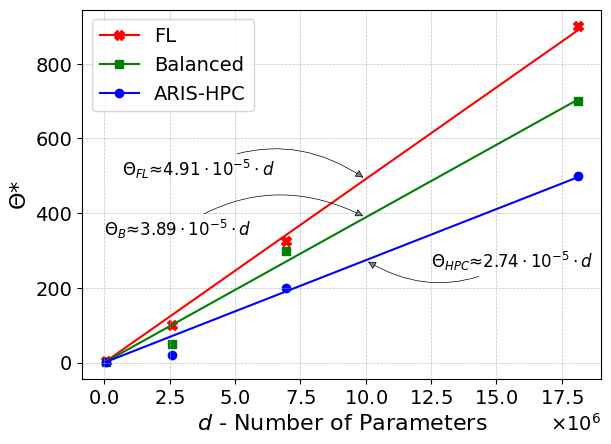

In [107]:
save_theta_approximation_plot()

# For Regression model

In [ ]:
df_fda_regression = df[df.fda_name.isin(['naive', 'linear', 'sketch'])].copy()

In [ ]:
df_fda_regression = df_fda_regression[(~df_fda_regression.per_layer) & (df_fda_regression['aggr_scheme'] == 'avg')]

In [ ]:
def local_state_computation_cost(row):
    if row['fda_name'] == 'naive':
        return row['nn_num_weights']  # O(d)
    if row['fda_name'] == 'linear':
        return 2*row['nn_num_weights']  #  O(2*d)
    if row['fda_name'] == 'sketch':
        return row['nn_num_weights'] * row['sketch_width'] * row['sketch_depth']  #  O(width * d)
    return None

In [ ]:
df_fda_regression['local_state_computation_cost'] = df_fda_regression.apply(local_state_computation_cost, axis=1)

In [ ]:
def monitoring_size(row):
    if row['fda_name'] == 'naive':
        return 1
    if row['fda_name'] == 'linear':
        return 2
    if row['fda_name'] == 'sketch':
        return 5 * 250
    return None

In [ ]:
def sample_size(ds_name):
    if ds_name == 'CIFAR10':
        return 32 * 32 * 3
    if ds_name == 'MNIST':
        return 28 * 28
    return None

In [ ]:
df_fda_regression['sample_size'] = df_fda_regression['dataset_name'].apply(sample_size)

In [ ]:
df_fda_regression['monitoring_size'] = df_fda_regression.apply(monitoring_size, axis=1)

In [ ]:
df_fda_regression['train_computation_cost'] = df_fda_regression['total_fda_steps'] * df_fda_regression['nn_num_weights'] * df_fda_regression['batch_size']

In [ ]:
df_fda_regression['dataset_computation_cost'] = df_fda_regression['total_fda_steps'] * df_fda_regression['sample_size']

In [ ]:
df_fda_regression['sync_communication_cost'] = df_fda_regression['total_rounds'] * df_fda_regression['nn_num_weights'] * np.log2(df_fda_regression['num_clients'])

In [ ]:
df_fda_regression['monitor_communication_cost'] = df_fda_regression['total_fda_steps'] * df_fda_regression['monitoring_size'] * np.log2(df_fda_regression['num_clients'])

In [ ]:
!cp /home/miketheologitis/TFD-FedL-Sync-FDA/notebooks/regression_model.pkl .

In [ ]:
import pickle

with open('regression_model.pkl', 'rb') as f:
    rmodel = pickle.load(f)

In [31]:
df_fda_regression['pred_total_time_sec'] = rmodel.predict(
    df_fda_regression[[
        'train_computation_cost', 
        'dataset_computation_cost', 
        'local_state_computation_cost', 
        'sync_communication_cost', 
        'monitor_communication_cost'
    ]]
)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
df_fda_regression['pred_total_time_minutes'] = df_fda_regression['pred_total_time_sec'] / 60.0